# Advanced Lane Finding

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import os
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Camera Calibration

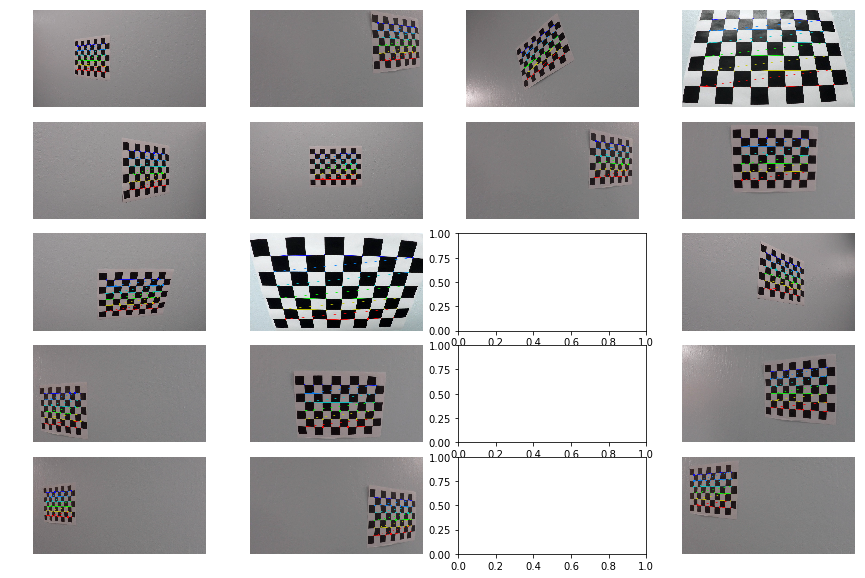

In [2]:
import glob
# Making a list of calibration images
cal_images = glob.glob('./camera_cal/calibration*.jpg')

# prepare object points
nx = 9 #TODO: enter the number of inside corners in x
ny = 6 #TODO: enter the number of inside corners in y

# prepare object pts
objp = np.zeros((nx*ny,3),np.float32)
objp[:,0:2] =np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object and impage points from all the images

objpoints = []  # 3D points in real world space
imgpoints = []  # 2D points in image plane

fig, axs = plt.subplots(5,4, figsize=(15, 10))
fig.subplots_adjust(hspace = .15, wspace=.15)

axs = axs.ravel()
for idx, fname in enumerate(cal_images):
    img = cv2.imread(fname)
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        # Draw and plot the cornersimg = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        axs[idx].axis('off')
        axs[idx].imshow(img)


The images that do not appear in the display are those where the specificied no. of corners were not detected.

# Distortion Correction

In [3]:
img_size = (img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

## # Visualizing Distorion

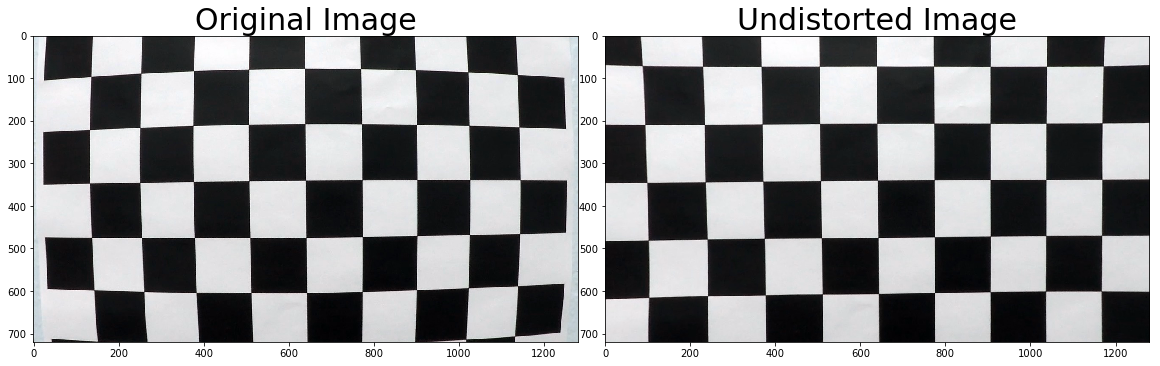

In [4]:
img = cv2.imread('./camera_cal/calibration1.jpg')
undist = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)


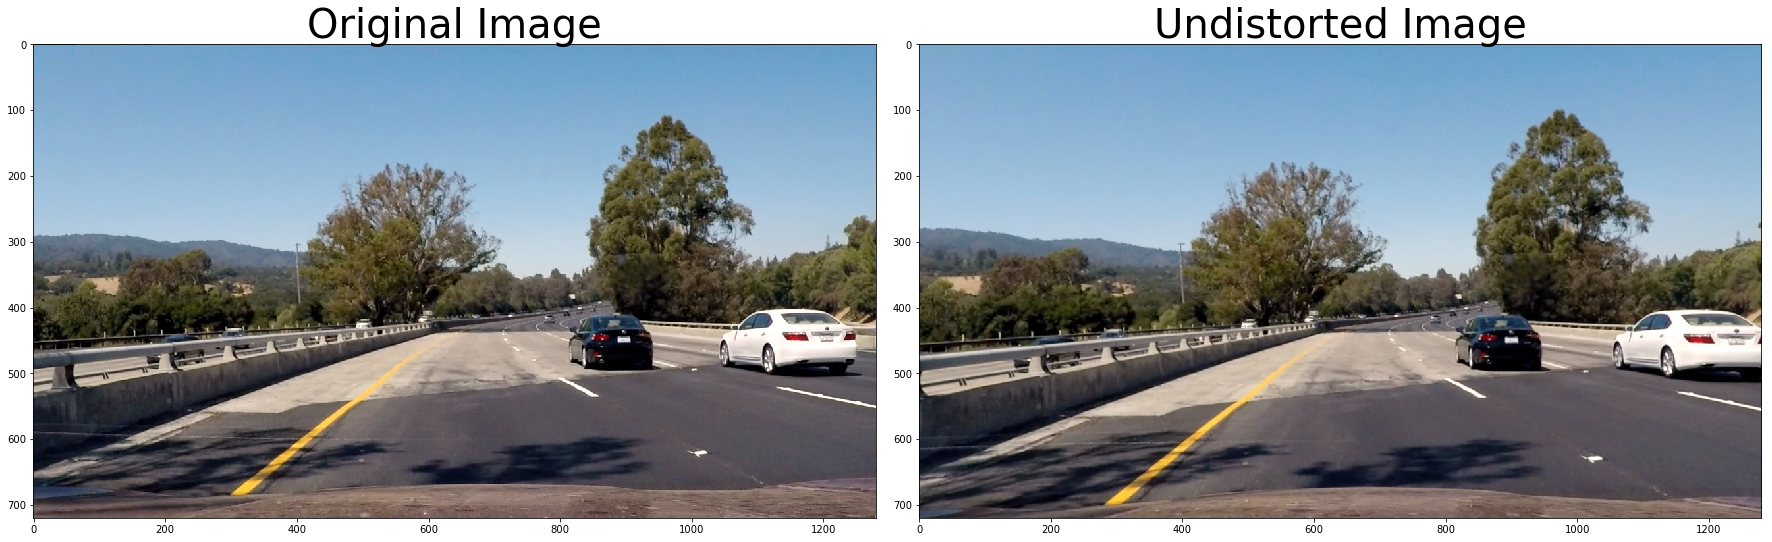

In [5]:

n = 1
list = os.listdir('./test_images')
img = mpimg.imread('./test_images/{}'.format(list[n]))
undistorted = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Color/gradient threshold

In [38]:
l_thresh = (225,255)
R_thresh =(200,255)
def colorAndThreshold(img, s_thresh = (190,255), sx_thresh = (20,100)):
    img = np.copy(img)
    R = img[:,:,0].astype(np.float)
    # Convert to HLS color space
    hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    
    s_channel = hls[:,:,2]

    #Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F,1,0) # Take the der in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate linws away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    s_channel = np.uint8(255*s_channel/np.max(s_channel))
    #Threshold color channel 
    s_binary = np.zeros_like(s_channel)
    s_binary = np.uint8(255*s_binary/np.max(s_binary))
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    #print(s_binary)
    
    l_channel = np.uint8(255*l_channel/np.max(l_channel))
    #Threshold l channel
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    R = np.uint8(255*R/np.max(R))
    #Threshold l channel
    R_binary = np.zeros_like(R)
    R_binary[(R >= R_thresh[0]) & (R <= R_thresh[1])] = 1

    # Stack each channel ton view their individual contributions in green and blue respectively
    color_binary = 255*np.dstack((np.zeros_like(s_binary),l_binary, s_binary))
    
    #Combination of two binary thresholds
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(sxbinary==1)|(l_binary ==1) | ((R_binary==1)&s_binary==1)]= 1
    
    return combined_binary,color_binary



Visulaizing color gradients/thresholding

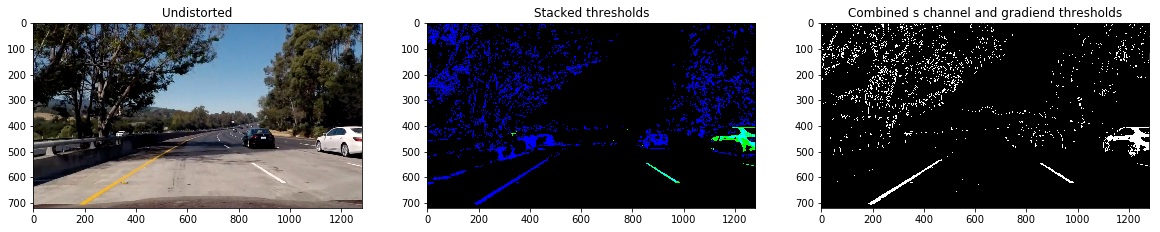

In [40]:
s_thresh = (150,255)
sx_thresh = (40,100)
img = cv2.imread('./test_images/test5.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undistorted = cal_undistort(img, objpoints, imgpoints)

combined_binary,color_binary = colorAndThreshold(undistorted,s_thresh ,sx_thresh)
#print(color_binary)
# Plotting thresholded images

f, (ax1,ax2,ax3) = plt.subplots(1,3, figsize = (20,10))

ax1.set_title('Undistorted')
ax1.imshow(undistorted)

ax2.set_title('Stacked thresholds')
ax2.imshow(color_binary)

ax3.set_title('Combined s channel and gradiend thresholds')
ax3.imshow(combined_binary, cmap = 'gray')

# Perspective Transfomation



In [8]:
def unwrap(img,src,dst):
    img_size =(img.shape[1],img.shape[0])
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    invM = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(img, M, img_size)
    return warped, M,invM

Visualizing

In [9]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def regionofInterestforPerspectiveTransformation(img,src):
    point1 = src[0]
    point2 = src[1]
    point3 = src[2]
    point4 = src[3]

    # vertices lines is the region of interest formed by lines
    vertices_lines=np.array([[[point1[0],point1[1],point2[0],point2[1]],[point2[0],point2[1],point3[0],point3[1]],\
                             [point3[0],point3[1],point4[0],point4[1]],\
                            [point4[0],point4[1],point1[0],point1[1]]]],dtype=np.int32)
    draw_poly = np.zeros_like(img)
    draw_poly = np.uint8(draw_poly)
    draw_lines(draw_poly,vertices_lines,color=[255,0,0],thickness=10)
    merge = weighted_img(img, draw_poly, α=1, β=1., λ=0.)
    return merge


[[  190.   720.]
 [  575.   464.]
 [  707.   464.]
 [ 1180.   720.]] 1280
[[ 400.  720.]
 [ 400.    0.]
 [ 880.    0.]
 [ 880.  720.]]


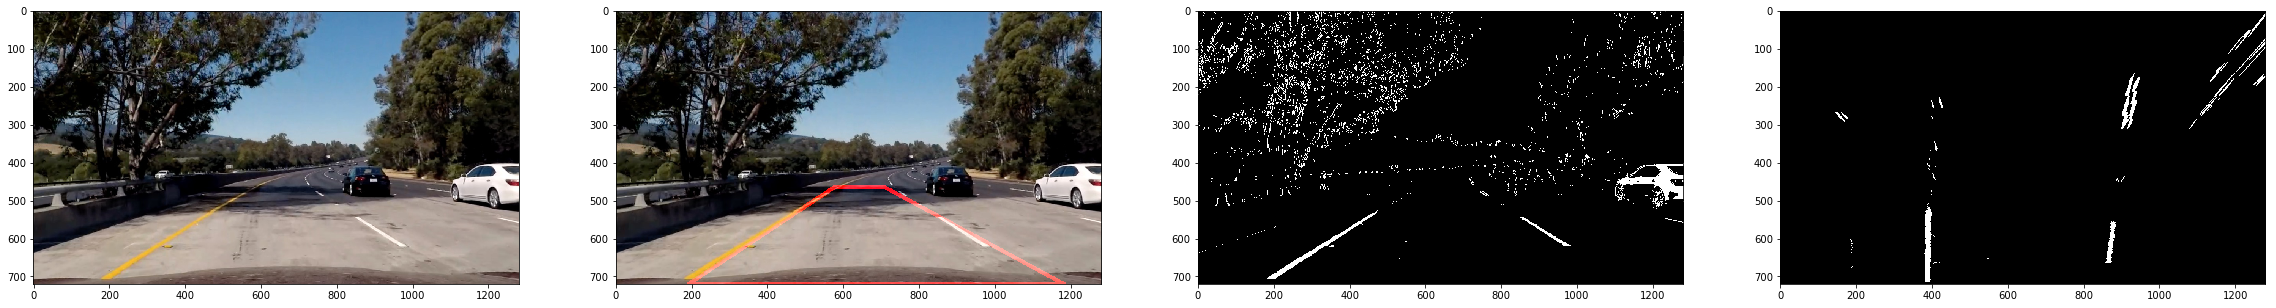

In [10]:
h,w = img.shape[:2]
#src = np.float32([[290,img.shape[0]-50],[570,470],[770,470],[1120,img.shape[0]-50]])

src = np.float32([(190,720),(575,464),(707,464),(1180,720)])
dst = np.float32([(400,h),
                  (400,0),
                  (w-400,0),
                  (w-400,h)])
print(src,w)
print(dst)
warped,M,invM = unwrap(combined_binary,src,dst)
merge = regionofInterestforPerspectiveTransformation(undistorted,src)

fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(40,20))
ax1.imshow(undistorted)
ax2.imshow(merge)
ax3.imshow(combined_binary,cmap = 'gray')
ax4.imshow(warped,cmap = 'gray')

AxesImage(54,36;334.8x217.44)


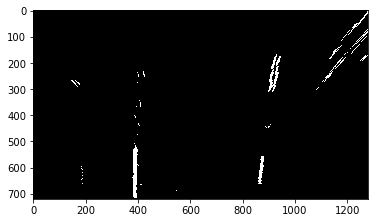

In [11]:
print(plt.imshow(warped,cmap='gray'))

# Image Processing Pipeline

In [12]:
def pipeline(img,src,dst,objpoints, imgpoints,s_thresh=(190,255),sx_thresh=(20,100)):
    
    undistorted = cal_undistort(img,objpoints, imgpoints)
    combined_binary,color_binary = colorAndThreshold(undistorted,s_thresh,sx_thresh)
    warped,M,invM = unwrap(combined_binary,src,dst)
    merge = regionofInterestforPerspectiveTransformation(undistorted,src)
    return undistorted,combined_binary,warped,merge,invM


    

### Run pipeline function on all test images

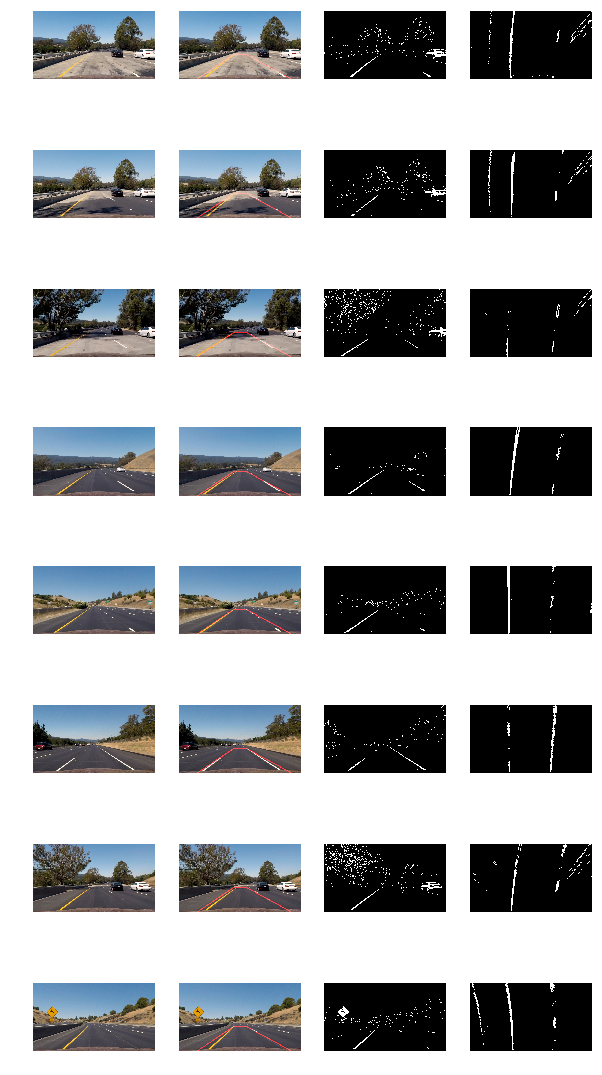

In [13]:
# Make a list of example images
images = glob.glob('./test_images/*.jpg')

fig, axs = plt.subplots(len(images),4, figsize=(10, 20))
#fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
i = 0               
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    undistorted,combined_binary,warped,merge,invM = pipeline(img,src,dst,objpoints, imgpoints,s_thresh,sx_thresh)
    axs[i].imshow(undistorted)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(merge)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(combined_binary,cmap='gray')
    axs[i].axis('off')
    i += 1
    axs[i].imshow(warped,cmap='gray')
    axs[i].axis('off')
    i += 1
    

#  Lane Detection

In [14]:
def sliding_window_polyfit(img):
    binary_warped = np.copy(img)
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    plt.plot(histogram)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 5) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 5) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit, left_lane_inds, right_lane_inds, histogram,out_img,nonzerox,nonzeroy


Visualizing sliding window 

(720, 0)

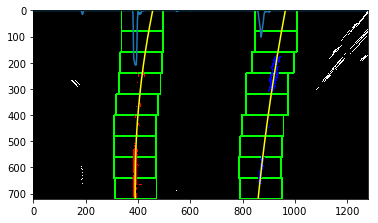

In [15]:
Test_Img = cv2.imread('./test_images/test5.jpg')
Test_Img = cv2.cvtColor(Test_Img, cv2.COLOR_BGR2RGB)

undistorted,combined_binary,warped,merge,invM = pipeline(Test_Img,src,dst,objpoints, \
                                                         imgpoints,s_thresh,sx_thresh)

left_fit, right_fit, left_lane_inds, right_lane_inds, histogram,out_img,nonzerox,nonzeroy = sliding_window_polyfit(warped)
# Generate x and y values for plotting
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

Done


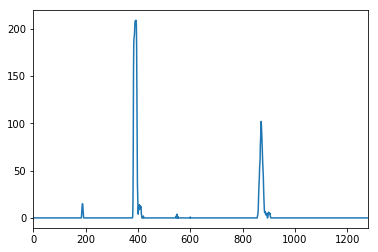

In [16]:
# Print histogram from sliding window polyfit for example image
plt.plot(histogram)
plt.xlim(0, 1280)
print('Done')


In [17]:
def polyfit_using_prev_fit(binary_warped, left_fit_prev, right_fit_prev):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & 
                      (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & 
                       (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds
print('...')

...


Done


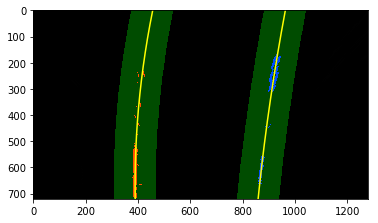

In [18]:
# visualize the result on example image
Test_Img2 = cv2.imread('./test_images/test5.jpg')
Test_Img2 = cv2.cvtColor(Test_Img2, cv2.COLOR_BGR2RGB)
undistorted2,combined_binary2,warped2,merge2,invM2 = pipeline(Test_Img2,src,dst,objpoints, \
                                                         imgpoints,s_thresh,sx_thresh)
 
margin = 80

left_fit2, right_fit2, left_lane_inds2, right_lane_inds2 = polyfit_using_prev_fit(warped2, left_fit, right_fit)

# Generate x and y values for plotting
ploty = np.linspace(0, warped2.shape[0]-1, warped2.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
left_fitx2 = left_fit2[0]*ploty**2 + left_fit2[1]*ploty + left_fit2[2]
right_fitx2 = right_fit2[0]*ploty**2 + right_fit2[1]*ploty + right_fit2[2]

# Create an image to draw on and an image to show the selection window
out_img = np.uint8(np.dstack((warped2, warped2, warped2)))
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
nonzero = warped2.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds2], nonzerox[left_lane_inds2]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds2], nonzerox[right_lane_inds2]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area (OLD FIT)
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx2, ploty, color='yellow')
plt.plot(right_fitx2, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
print('Done')

### Radius of Curvatre and Offset from lane centre

In [19]:
# Method to determine radius of curvature and distance from lane center 
# based on binary image, polynomial fit, and L and R lane pixel indices
def calc_curv_rad_and_center_dist(warped, l_fit, r_fit, l_lane_inds, r_lane_inds):
    bin_img = np.copy(warped)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension, lane line is 10 ft = 3.048 meters
    xm_per_pix = 3.7/480#378 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters
    left_curverad, right_curverad, center_dist = (0, 0, 0)
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    h = bin_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
  
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
    
    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    if r_fit is not None and l_fit is not None:
        car_position = bin_img.shape[1]/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
    return left_curverad, right_curverad, center_dist
print('Done')

Done


In [20]:
rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(warped, left_fit, right_fit, left_lane_inds, right_lane_inds)

print('Radius of curvature for test image:', rad_l, 'm,', rad_r, 'm')
print('Distance from lane center for test_image:', d_center, 'm')

Radius of curvature for test image: 744.980523449 m, 1882.26050658 m
Distance from lane center for test_image: 0.11949442572 m


### Draw the lane on original image 

In [21]:
def draw_lane(original_img, binary_img, l_fit, r_fit, Minv):
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result
print('Done')

Done


Done


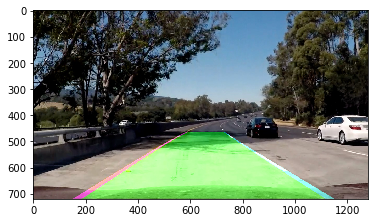

In [22]:
Test_Img_out1 = draw_lane(Test_Img, warped, left_fit, right_fit, invM)
plt.imshow(Test_Img_out1)
print('Done')

### Draw Radius of Curvature on the Image

In [23]:
def draw_data(original_img, curv_rad, center_dist):
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img


Done


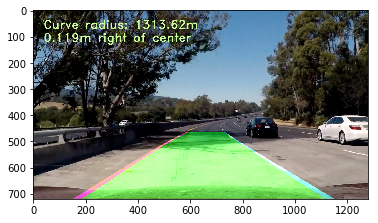

In [24]:
Test_Img_out2 = draw_data(Test_Img_out1, (rad_l+rad_r)/2, d_center)
plt.imshow(Test_Img_out2)
print('Done')

### Storing data

In [25]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None
    def add_fit(self, fit, inds):
        # add a found fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or self.diffs[1] > 1.0 or self.diffs[2] > 100.) and len(self.current_fit) > 0:
                # bad fit! abort! abort! ... well, unless there are no fits in the current_fit queue, then we'll take it
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # throw out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # or remove one from the history, if not found
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)


print('...')

...


### Pipeline for video 

In [26]:
def process_image(img):
    new_img = np.copy(img)
    undistorted,combined_binary,img_bin,merge,Minv = pipeline(new_img,src,dst,objpoints, imgpoints,s_thresh,sx_thresh)
    
    # if both left and right lines were detected last frame, use polyfit_using_prev_fit, otherwise use sliding window
    if not l_line.detected or not r_line.detected:
        l_fit, r_fit, l_lane_inds, r_lane_inds, _,_,_,_ = sliding_window_polyfit(img_bin)
    else:
        l_fit, r_fit, l_lane_inds, r_lane_inds = polyfit_using_prev_fit(img_bin, l_line.best_fit, r_line.best_fit)
        
#     #invalidate both fits if the difference in their x-intercepts isn't around 350 px (+/- 100 px)
#     if l_fit is not None and r_fit is not None:
#         # calculate x-intercept (bottom of image, x=image_height) for fits
#         h = img.shape[0]
#         l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
#         r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
#         x_int_diff = abs(r_fit_x_int-l_fit_x_int)
#         if abs(680 - x_int_diff) > 100:
#             l_fit = None
#             r_fit = None
            
    l_line.add_fit(l_fit, l_lane_inds)
    r_line.add_fit(r_fit, r_lane_inds)
    
    # draw the current best fit if it exists
    if l_line.best_fit is not None and r_line.best_fit is not None:
        img_out1 = draw_lane(undistorted, img_bin, l_line.best_fit, r_line.best_fit, Minv)
        rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(img_bin, l_line.best_fit, r_line.best_fit, 
                                                               l_lane_inds, r_lane_inds)
        img_out = draw_data(img_out1, (rad_l+rad_r)/2, d_center)
    else:
        img_out = new_img
        
    return img_out
print('Done')

Done


### Project Video

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [05:43<00:00,  4.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 4min 43s, sys: 33.2 s, total: 5min 16s
Wall time: 5min 46s


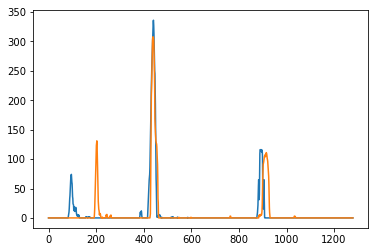

In [27]:
l_line = Line()
r_line = Line()
#my_clip.write_gif('test.gif', fps=12)
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)

In [28]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output1))